<a href="https://colab.research.google.com/github/ryanditata/dataMining/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Load dataset dari Excel
df = pd.read_excel("exim_bulanan.xlsx")
print(df)

      Bulan  Nilai Ekspor (USD)  Berat Ekspor (Kg)  Nilai Impor (USD)  \
0   Januari        2.142828e+10       5.525196e+10       1.793592e+10   
1  Februari        2.194418e+10       5.661884e+10       1.884900e+10   
2     Maret        2.324726e+10       5.764813e+10       1.891998e+10   
3     April        2.074385e+10       5.328238e+10       2.058501e+10   
4       Mei        2.461380e+10       5.912187e+10       2.031230e+10   
5      Juni        2.343646e+10       5.235006e+10       1.933295e+10   
6      Juli        2.474886e+10       5.890011e+10       2.057541e+10   
7   Agustus        2.496317e+10       6.682619e+10       1.947524e+10   

   Berat Impor (Kg)  
0      1.565938e+10  
1      2.014542e+10  
2      1.900241e+10  
3      1.853537e+10  
4      2.034686e+10  
5      2.041613e+10  
6      1.990940e+10  
7      1.994428e+10  


In [ ]:
# Ubah kolom periode menjadi datetime
bulan_map = {
             'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
             'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
             'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

# Tambahkan kolom periode
df['Bulan_num'] = df['Bulan'].map(bulan_map)
df['Periode'] = pd.to_datetime(dict(year=2025, month=df['Bulan_num'], day=1))

# Urutkan
df = df.sort_values(by='Periode').reset_index(drop=True)

# Rename kolom
df = df.rename(columns={
    'Nilai Ekspor (USD)': 'Ekspor',
    'Berat Ekspor (Kg)': 'Ekspor_kg',
    'Nilai Impor (USD)': 'Impor',
    'Berat Impor (Kg)': 'Impor_kg'
})

# Cek missing value
print(df.isnull().sum())

# Hilangkan missing value jika ada
df = df.interpolate()


Bulan        0
Ekspor       0
Ekspor_kg    0
Impor        0
Impor_kg     0
Bulan_num    0
Periode      0
dtype: int64


/tmp/ipython-input-2134127347.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


In [ ]:
# Tambahkan Neraca Perdagangan
df['Neraca'] = df['Ekspor'] - df['Impor']

# Growth Rate (%)
df['Ekspor_Growth'] = df['Ekspor'].pct_change() * 100
df['Impor_Growth'] = df['Impor'].pct_change() * 100

# Normalisasi untuk modeling
scaler = MinMaxScaler()
df[['Ekspor_norm','Impor_norm']] = scaler.fit_transform(df[['Ekspor','Impor']])

print(df)

      Bulan        Ekspor     Ekspor_kg         Impor      Impor_kg  \
0   Januari  2.142828e+10  5.525196e+10  1.793592e+10  1.565938e+10   
1  Februari  2.194418e+10  5.661884e+10  1.884900e+10  2.014542e+10   
2     Maret  2.324726e+10  5.764813e+10  1.891998e+10  1.900241e+10   
3     April  2.074385e+10  5.328238e+10  2.058501e+10  1.853537e+10   
4       Mei  2.461380e+10  5.912187e+10  2.031230e+10  2.034686e+10   
5      Juni  2.343646e+10  5.235006e+10  1.933295e+10  2.041613e+10   
6      Juli  2.474886e+10  5.890011e+10  2.057541e+10  1.990940e+10   
7   Agustus  2.496317e+10  6.682619e+10  1.947524e+10  1.994428e+10   

   Bulan_num    Periode        Neraca  Ekspor_Growth  Impor_Growth  \
0          1 2025-01-01  3.492367e+09            NaN           NaN   
1          2 2025-02-01  3.095181e+09       2.407553      5.090814   
2          3 2025-03-01  4.327285e+09       5.938168      0.376563   
3          4 2025-04-01  1.588327e+08     -10.768647      8.800414   
4         

In [ ]:
train_size = int(len(df)*0.8)
train, test = df['Ekspor'][:train_size], df['Ekspor'][train_size:]

# Model ARIMA
model = ARIMA(train, order=(1,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

In [ ]:
# Evaluasi dengan MAE dan RMSE
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1405532601.3071613
RMSE: 1409617720.7798722


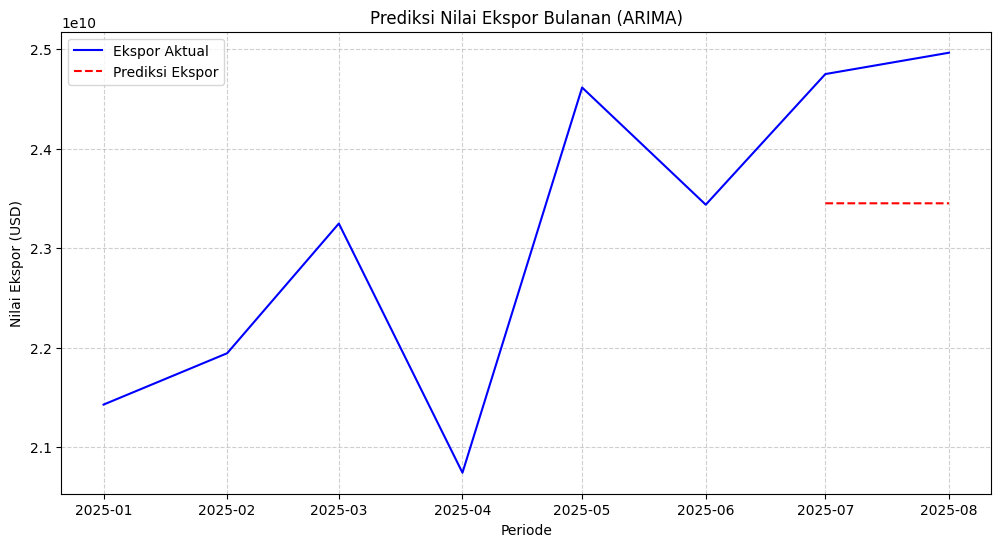

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['Periode'], df['Ekspor'], label='Ekspor Aktual', color='blue')
plt.plot(df.loc[test.index,'Periode'], forecast, label='Prediksi Ekspor', color='red', linestyle='--')
plt.title('Prediksi Nilai Ekspor Bulanan (ARIMA)')
plt.xlabel('Periode')
plt.ylabel('Nilai Ekspor (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

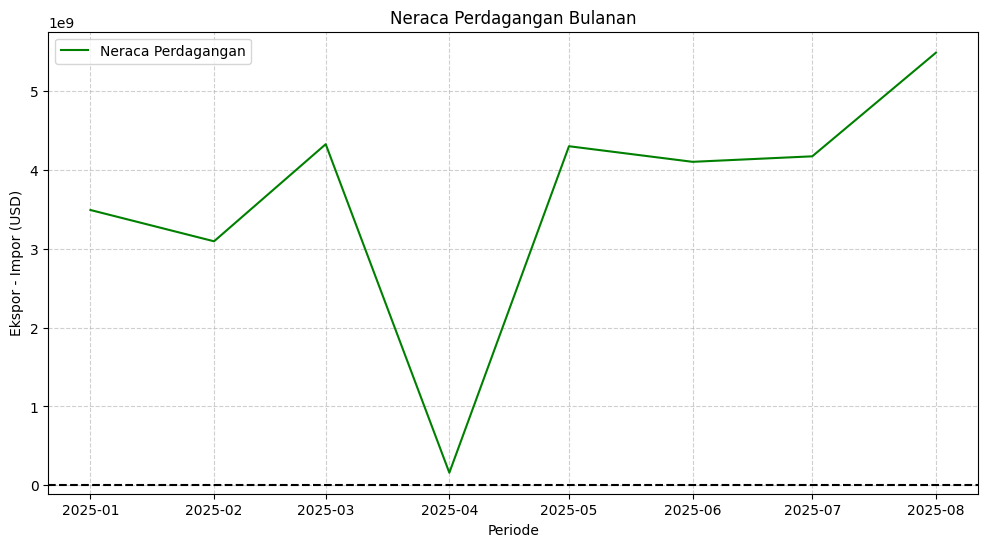

In [ ]:
# Visualisasi Neraca Perdagangan
plt.figure(figsize=(12,6))
plt.plot(df['Periode'], df['Neraca'], label='Neraca Perdagangan', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Neraca Perdagangan Bulanan')
plt.xlabel('Periode')
plt.ylabel('Ekspor - Impor (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()